# Benchmark against other methods

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os.path
sys.path.append('../../src/libraries')  # import YeaZ

from glob import glob
from tqdm import tqdm
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, matplotlib.transforms as mtransforms, seaborn as sns
import itertools, json, pickle
from collections import defaultdict
from pathlib import Path

from sklearn.metrics import confusion_matrix
from bread.data import *
from bread.algo import tracking
from bread import vis

## Load testing data

In [16]:
seg = Segmentation.from_h5('../../data/data_from_LPBS/colony005_segmentation.h5')
microscopy = Microscopy.from_tiff('../../data/data_from_LPBS/colony005_microscopy.tif')
feat = Features(seg, nn_threshold=12, scale_length=1, scale_time=1)

In [4]:
max_dt = 4
interframes = [(idt, idt+dt) for idt, dt in itertools.product(range(len(seg)), range(1, max_dt+1)) if idt+dt < len(seg)]
print(f'{len(interframes)} interframe samples')

714 interframe samples


In [5]:
results = { 'gcn': {}, 'yeaz': {}, 'tracx': {} }

In [6]:
recompute = True  # notebook flag to force recomputing the accuracies

In [7]:
basedir = Path('../../data/generated/tracking/compare/lpbs_colony005')  # directory for results

## Our method (GCN)

In [9]:
modelpath = Path('../../data/generated/tracking/models/2023-02-15 16:17:30/')

### Load model from pickle

In [10]:
with open(modelpath / 'pickle.pkl', 'rb') as file:
	net: tracking.AssignmentClassifier = pickle.load(file)

net.trim_for_prediction()
net

<class 'bread.algo.tracking._classifier.AssignmentClassifier'>[initialized](
  module_=GNNTracker(
    (node_encoder): MLP(12, 120, 120, 120, 120)
    (edge_encoder): MLP(10, 120, 120, 120, 120)
    (layers): ModuleList(
      (0): DeepGCNLayer(block=res+)
      (1): DeepGCNLayer(block=res+)
      (2): DeepGCNLayer(block=res+)
      (3): DeepGCNLayer(block=res+)
      (4): DeepGCNLayer(block=res+)
    )
    (out): MLP(120, 60, 30, 1)
  ),
)

In [ ]:
ga = tracking.build_assgraph(tracking.build_cellgraph(feat, 50), tracking.build_cellgraph(feat, 55), include_target_feature=True)
gat, *_ = tracking.to_data(ga)
yhat = net.predict_assignment(gat)
print(yhat)
yhat = yhat.flatten()
y = gat.y.squeeze().cpu().numpy()
confusion_matrix(y, yhat.flat)

[[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1]]


array([[56,  0],
       [ 0,  8]])

### Load model from params

In [19]:
from bread.algo.tracking import GraphLoader, GNNTracker, InMemoryAssignmentDataset
from skorch.classifier import NeuralNetClassifier
import torch

with open(modelpath / 'hyperparams.json') as file:
	hparams = json.load(file)

# first initialize the model
new_net = NeuralNetClassifier(
	GNNTracker,
	module__num_node_attr=hparams['num_node_attr'],
	module__num_edge_attr=hparams['num_edge_attr'],
	module__dropout_rate=hparams['dropout_rate'],
	module__encoder_hidden_channels=hparams['encoder_hidden_channels'],
	module__encoder_num_layers=hparams['encoder_num_layers'],
	module__conv_hidden_channels=hparams['conv_hidden_channels'],
	module__conv_num_layers=hparams['conv_num_layers'],
	module__num_classes=1,
	iterator_train=GraphLoader,
	iterator_valid=GraphLoader,
	criterion=torch.nn.BCEWithLogitsLoss,
).initialize()
new_net.load_params(modelpath / 'params.pt')

dataset = InMemoryAssignmentDataset([
	tracking.to_data(tracking.build_assgraph(tracking.build_cellgraph(feat, 50), tracking.build_cellgraph(feat, 55), include_target_feature=True))[0]
])
# unactivated outputs
print(new_net.forward(dataset[0:1]).reshape((len(dataset[0].cell_ids1), len(dataset[0].cell_ids2))))
# activated outputs
# WARNING : this is just applying a rounding operation, this is not the linear assignment !!
print(new_net.predict(dataset[0:1]).reshape((len(dataset[0].cell_ids1), len(dataset[0].cell_ids2))))

tensor([[13.3592, -4.4377, -4.4081, -4.4905, -4.6378, -4.5045, -4.4877, -4.5027],
        [-4.3972, 17.6632, -4.4606, -4.4377, -4.4029, -4.4324, -4.4382, -4.4733],
        [-4.3913, -4.4499, 17.7682, -4.4430, -4.6403, -4.4511, -4.4744, -4.5071],
        [-4.4749, -4.4526, -4.4384, 13.4757, -4.4328, -4.4471, -4.4515, -4.4892],
        [-4.3958, -4.4302, -4.7050, -4.4319, 15.7202, -4.5037, -4.5424, -4.5112],
        [-4.4282, -4.4556, -4.4576, -4.4425, -4.4848, 17.6063, -4.4331, -3.9462],
        [-4.4775, -4.4388, -4.4884, -4.3698, -4.4417, -4.4293, 15.5711, -4.4827],
        [-4.4952, -4.4134, -4.5196, -4.5156, -4.5346, -3.4533, -4.4809, 15.7358]])
[[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1]]


### compute

In [12]:
if recompute:
	results['gcn'] = {
		't1': [],
		't2': [],
		'confusion': []
	}

	for idt1, idt2 in tqdm(interframes):
		ga = tracking.build_assgraph(tracking.build_cellgraph(feat, idt1), tracking.build_cellgraph(feat, idt2), include_target_feature=True)
		gat, *_ = tracking.to_data(ga)

		yhat = net.predict_assignment(gat).flatten()
		y = gat.y.squeeze().cpu().numpy()

		results['gcn']['confusion'].append(confusion_matrix(y, yhat))
		results['gcn']['t1'].append(idt1)
		results['gcn']['t2'].append(idt2)

100%|██████████| 714/714 [02:20<00:00,  5.10it/s]


## YeaZ

In [14]:
import YeaZ.unet.hungarian as YeaZ_hung

In [15]:
import scipy.spatial.distance

def match_cellids_from_segs(segframe1: np.ndarray, segframe2: np.ndarray, eps=1e-6):
	# Matches cellids between two identical segmentations, which use different numberings
	seg1 = Segmentation(segframe1[None, ...])
	seg2 = Segmentation(segframe2[None, ...])
	cms1 = seg1.cms(0)
	cms2 = seg2.cms(0)

	# compare centers of masses
	dists = scipy.spatial.distance.cdist(cms1, cms2)
	matches = dists < eps
	idx1, idx2 = matches.nonzero()
	assert not len(idx2) < len(cms1), 'not all cells were matched'
	assert not len(idx2) > len(cms1), 'too many cells were matched'
	
	return idx2

In [16]:
if recompute:
	results['yeaz'] = {
		't1': [],
		't2': [],
		'confusion': []
	}

	for idt1, idt2 in tqdm(interframes):
		seg_hat = YeaZ_hung.correspondence(seg[idt1], seg[idt2])
		idmap2 = match_cellids_from_segs(seg[idt2], seg_hat)

		y = tracking.assignment_from_segmentation(seg, idt1, idt2)
		yhat = tracking.assignment_from_segmentation(seg, idt1, idt2)[:, idmap2]
		
		results['yeaz']['confusion'].append(confusion_matrix(y.flatten(), yhat.flatten()))
		results['yeaz']['t1'].append(idt1)
		results['yeaz']['t2'].append(idt2)

100%|██████████| 714/714 [00:31<00:00, 22.98it/s]


## TracX

In [17]:
# since tracx works with matlab, we need to export the data to a convenient format
# then run it via matlab
# then analyze the results

import tifffile

fileid2frameid = defaultdict(dict)
dowrite = False

for dt in range(1, max_dt+1):
	outdir = str(basedir / 'TracX/framediff{:02d}').format(dt)
	os.makedirs(outdir, exist_ok=True)
	fileid = 0
	for startframe in range(0, dt):
		for frameid in range(startframe, len(seg), dt):
			fileid2frameid[dt][fileid] = frameid
			if dowrite:
				tifffile.imsave(f'{outdir}/mask_{fileid:03d}.tif', seg[frameid])
				tifffile.imsave(f'{outdir}/phc_{fileid:03d}.tif', microscopy[frameid])
			fileid += 1

if dowrite:
	with open(basedir / 'TracX/fileid2frameid.json', 'w') as f:
		json.dump(fileid2frameid, f)

In [18]:
# run the tracking in matlab and generate results in basedir / TracX_results/ ...

In [19]:
dfs_tracx_res = []

for framediff in range(1, max_dt+1):
	filepath = basedir / f'TracX_results/TrackingResults_framediff{framediff:02d}.txt'
	df = pd.read_csv(filepath, sep='\t', usecols=['cell_frame', 'cell_index', 'track_index'])
	df['frameid'] = df.cell_frame.map(lambda f: fileid2frameid[1][f-1])
	df.drop(columns='cell_frame', inplace=True)
	df['framediff'] = framediff
	dfs_tracx_res.append(df)

df_tracx_res = pd.concat(dfs_tracx_res)

In [20]:
if recompute:
	results['tracx'] = {
		't1': [],
		't2': [],
		'confusion': []
	}

	for _, group_framediff in df_tracx_res.groupby('framediff'):
		framediff = group_framediff.framediff.iloc[0]

		for (_, group1), (_, group2) in itertools.product(group_framediff.groupby('frameid'), repeat=2):
			idt1, idt2 = group1.frameid.iloc[0], group2.frameid.iloc[0]

			# loop only over idt -> idt+framediff
			if idt2 - idt1 != framediff or idt2 < idt1:
				continue

			ass_tracx = np.empty((len(group1.cell_index), len(group2.cell_index)))
			ass = np.empty((len(group1.cell_index), len(group2.cell_index)))

			for idx1, idx2 in itertools.product(range(len(group1.cell_index)), range(len(group2.cell_index))):
				ass_tracx[idx1, idx2] = group1.track_index.iloc[idx1] == group2.track_index.iloc[idx2]
				# the input to TracX are segmentations where the cellids are already tracked correctly
				# so the tracking is just where the cell indices match
				ass[idx1, idx2] = group1.cell_index.iloc[idx1] == group2.cell_index.iloc[idx2]

			results['tracx']['confusion'].append(confusion_matrix(ass.flatten(), ass_tracx.flatten()))
			results['tracx']['t1'].append(idt1)
			results['tracx']['t2'].append(idt2)

## Compare results

### Create results dataframe

In [21]:
resultsfile = basedir / 'results.csv'

if recompute:
	dfs = []

	for method in results:
		res = pd.DataFrame(results[method])
		res['method'] = method
		dfs.append(res)

	res = pd.concat(dfs, ignore_index=True)

	num_cells = [ len(seg.cell_ids(idt)) for idt in range(len(seg)) ]

	res['tp'] = res['confusion'].map(lambda c: c[1,1])
	res['fp'] = res['confusion'].map(lambda c: c[0,1])
	res['tn'] = res['confusion'].map(lambda c: c[0,0])
	res['fn'] = res['confusion'].map(lambda c: c[1,0])
	res['acc'] = (res['tp'] + res['tn']) / (res['tp'] + res['fp'] + res['tn'] + res['fn'])
	res['f1'] = 2*res['tp'] / (2*res['tp'] + res['fp'] + res['fn'])
	res['num_cells1'] = res['t1'].map(lambda t: num_cells[t])
	res['num_cells2'] = res['t2'].map(lambda t: num_cells[t])
	res['timediff'] = 5 * (res['t2'] - res['t1'])
	res.drop(columns='confusion', inplace=True)
	res.to_csv(resultsfile)

else:
	res = pd.read_csv(resultsfile, index_col=0)

In [22]:
res

t1   t2 method  tp  fp    tn  fn       acc        f1  num_cells1  \
0       0    1    gcn   2   0     2   0  1.000000  1.000000           2   
1       0    2    gcn   2   0     2   0  1.000000  1.000000           2   
2       0    3    gcn   2   0     4   0  1.000000  1.000000           2   
3       0    4    gcn   2   0     4   0  1.000000  1.000000           2   
4       1    2    gcn   2   0     2   0  1.000000  1.000000           2   
...   ...  ...    ...  ..  ..   ...  ..       ...       ...         ...   
2133  171  175  tracx  24   0   832   2  0.997669  0.960000          36   
2134  172  176  tracx  25   0   952   3  0.996939  0.943396          36   
2135  173  177  tracx  25   0  1015   4  0.996169  0.925926          36   
2136  174  178  tracx  30   0  1116   1  0.999128  0.983607          36   
2137  175  179  tracx  31   1  1220   2  0.997608  0.953846          37   

      num_cells2  timediff  
0              2         5  
1              2        10  
2              3        15  
3              3        20  
4              2         5  
...          ...       ...  
2133          37        20  
2134          37        20  
2135          37        20  
2136          38        20  
2137          38        20  

[2138 rows x 12 columns]

### Sanity checks

In [23]:
res.groupby(['timediff', 'method'])[['acc']].count()

acc
timediff method     
5        gcn     180
         tracx   179
         yeaz    180
10       gcn     179
         tracx   178
         yeaz    179
15       gcn     178
         tracx   177
         yeaz    178
20       gcn     177
         tracx   176
         yeaz    177

In [24]:
res.groupby(['method', 'timediff'])[['acc']].mean()

acc
method timediff          
gcn    5         0.999913
       10        0.999892
       15        0.999811
       20        0.999598
tracx  5         0.999117
       10        0.998544
       15        0.996570
       20        0.995003
yeaz   5         0.999856
       10        0.995944
       15        0.991994
       20        0.991746

### Evaluate CI & plot

In [25]:
from scipy.stats import bootstrap

In [26]:
def frac_perfect(col):
	return (col == 1.0).sum() / len(col)

In [27]:
def frac_perfect_ci(col):
	# we need to test this otherwise scipy complains about degeneracy
	if all(col == 1):
		return (1.0, 1.0)
	bs = bootstrap((col,), statistic=frac_perfect, vectorized=False, random_state=0)
	return bs.confidence_interval.low, bs.confidence_interval.high

def mean_ci(col):
	if all(col == 1):
		return (1.0, 1.0)
	bs = bootstrap((col,), statistic=np.mean, vectorized=False, random_state=0)
	return bs.confidence_interval.low, bs.confidence_interval.high

In [28]:
res_agg = (res
	.groupby(['timediff', 'method'])
	[['acc']]
	.agg([frac_perfect, frac_perfect_ci, np.mean, mean_ci, np.median])
	.reset_index()
)
res_agg[[('acc', 'frac_perfect_ci_lower'), ('acc', 'frac_perfect_ci_higher')]] = pd.DataFrame(res_agg[('acc','frac_perfect_ci')].tolist(), index=res_agg.index)
res_agg[[('acc', 'mean_ci_lower'), ('acc', 'mean_ci_higher')]] = pd.DataFrame(res_agg[('acc','mean_ci')].tolist(), index=res_agg.index)
res_agg.drop(columns=[('acc', 'mean_ci'), ('acc', 'frac_perfect_ci')], inplace=True)
res_agg

timediff method          acc                                         \
                   frac_perfect      mean median frac_perfect_ci_lower   
0         5    gcn     0.994444  0.999913    1.0              0.961120   
1         5  tracx     0.944134  0.999117    1.0              0.893855   
2         5   yeaz     0.983333  0.999856    1.0              0.944444   
3        10    gcn     0.983240  0.999892    1.0              0.944134   
4        10  tracx     0.842697  0.998544    1.0              0.780899   
5        10   yeaz     0.944134  0.995944    1.0              0.893855   
6        15    gcn     0.955056  0.999811    1.0              0.904494   
7        15  tracx     0.706215  0.996570    1.0              0.632768   
8        15   yeaz     0.898876  0.991994    1.0              0.842697   
9        20    gcn     0.903955  0.999598    1.0              0.847458   
10       20  tracx     0.625000  0.995003    1.0              0.545455   
11       20   yeaz     0.853107  0.991746    1.0              0.790960   

                                                        
   frac_perfect_ci_higher mean_ci_lower mean_ci_higher  
0                1.000000      0.999390       1.000000  
1                0.966480      0.996393       0.999831  
2                0.994444      0.999455       0.999966  
3                0.994413      0.999491       0.999987  
4                0.887640      0.995947       0.999360  
5                0.966480      0.980804       0.999744  
6                0.977528      0.999483       0.999933  
7                0.763960      0.993660       0.997919  
8                0.932584      0.973391       0.999454  
9                0.937853      0.999268       0.999777  
10               0.687500      0.992234       0.996581  
11               0.892655      0.972994       0.999253

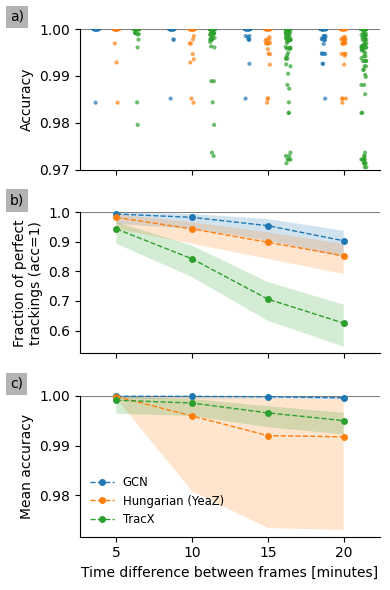

In [29]:
fig, axs = plt.subplot_mosaic([['a)'], ['b)'], ['c)']], figsize=(4, 6), sharex=True, tight_layout=True)

axs['b)'].axhline(1.0, color='tab:gray')
axs['b)'].fill_between(res_agg.timediff[res_agg.method == 'gcn'], res_agg.acc.frac_perfect_ci_lower[res_agg.method == 'gcn'], res_agg.acc.frac_perfect_ci_higher[res_agg.method == 'gcn'],
	alpha=0.2)
axs['b)'].plot(res_agg.timediff[res_agg.method == 'gcn'], res_agg.acc.frac_perfect[res_agg.method == 'gcn'],
	'o--', markersize=4, linewidth=1,
	label='GCN', clip_on=False)
axs['b)'].fill_between(res_agg.timediff[res_agg.method == 'yeaz'], res_agg.acc.frac_perfect_ci_lower[res_agg.method == 'yeaz'], res_agg.acc.frac_perfect_ci_higher[res_agg.method == 'yeaz'],
	alpha=0.2)
axs['b)'].plot(res_agg.timediff[res_agg.method == 'yeaz'], res_agg.acc.frac_perfect[res_agg.method == 'yeaz'],
	'o--', markersize=4, linewidth=1,
	label='Hungarian (YeaZ)', clip_on=False)
axs['b)'].fill_between(res_agg.timediff[res_agg.method == 'tracx'], res_agg.acc.frac_perfect_ci_lower[res_agg.method == 'tracx'], res_agg.acc.frac_perfect_ci_higher[res_agg.method == 'tracx'],
	alpha=0.2)
axs['b)'].plot(res_agg.timediff[res_agg.method == 'tracx'], res_agg.acc.frac_perfect[res_agg.method == 'tracx'],
	'o--', markersize=4, linewidth=1,
	label='TracX', clip_on=False)
# axs['b)'].set_xlabel('Time difference between frames [minutes]')
axs['b)'].set_ylabel('Fraction of perfect\ntrackings (acc=1)')
axs['b)'].spines.top.set_visible(False)
axs['b)'].spines.right.set_visible(False)
# axs['b)'].legend(fontsize='small', frameon=False)
axs['b)'].set_ylim((None, 1.0))

axs['c)'].axhline(1.0, color='tab:gray')
axs['c)'].fill_between(res_agg.timediff[res_agg.method == 'gcn'], res_agg.acc['mean_ci_lower'][res_agg.method == 'gcn'], res_agg.acc['mean_ci_higher'][res_agg.method == 'gcn'],
	alpha=0.2)
axs['c)'].plot(res_agg.timediff[res_agg.method == 'gcn'], res_agg.acc['mean'][res_agg.method == 'gcn'],
	'o--', markersize=4, linewidth=1,
	label='GCN', clip_on=False)
axs['c)'].fill_between(res_agg.timediff[res_agg.method == 'yeaz'], res_agg.acc['mean_ci_lower'][res_agg.method == 'yeaz'], res_agg.acc['mean_ci_higher'][res_agg.method == 'yeaz'],
	alpha=0.2)
axs['c)'].plot(res_agg.timediff[res_agg.method == 'yeaz'], res_agg.acc['mean'][res_agg.method == 'yeaz'],
	'o--', markersize=4, linewidth=1,
	label='Hungarian (YeaZ)', clip_on=False)
axs['c)'].fill_between(res_agg.timediff[res_agg.method == 'tracx'], res_agg.acc['mean_ci_lower'][res_agg.method == 'tracx'], res_agg.acc['mean_ci_higher'][res_agg.method == 'tracx'],
	alpha=0.2)
axs['c)'].plot(res_agg.timediff[res_agg.method == 'tracx'], res_agg.acc['mean'][res_agg.method == 'tracx'],
	'o--', markersize=4, linewidth=1,
	label='TracX', clip_on=False)
axs['c)'].set_ylabel('Mean accuracy')
axs['c)'].spines.top.set_visible(False)
axs['c)'].spines.right.set_visible(False)
axs['c)'].legend(fontsize='small', frameon=False)
axs['c)'].set_ylim((None, 1.0))
axs['c)'].set_xlabel('Time difference between frames [minutes]')

sns.stripplot(
	data=res, x='timediff', y='acc', hue='method',
	dodge=True, s=3, alpha=0.7, ax=axs['a)'], legend=False, native_scale=True,
	# clip_on=False,
)
axs['a)'].axhline(1.0, color='tab:gray')
axs['a)'].set_ylim((0.97, 1))  # some outliers from YeaZ and trackx are not shown !!
axs['a)'].set_ylabel('Accuracy')
axs['a)'].set_xlabel('Time difference between frames [minutes]')
axs['a)'].set_xticks(res_agg.timediff.unique())
axs['a)'].spines.top.set_visible(False)
axs['a)'].spines.right.set_visible(False)

for label, ax in axs.items():
    # label physical distance in and down
    trans = mtransforms.ScaledTranslation(-0.7, 0.05, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='bottom',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
			
# fig.savefig('../report_gnn/figures/timediff_accuracy.pdf')
plt.show()

### Evaluate p-value from bootstrapped samples

In [36]:
from typing import Callable
from scipy.stats import ttest_ind

def bootstrap_sample(
	x: np.ndarray,
	n: int = 10_000,
	agg: Callable[[np.ndarray], float] = np.mean
) -> np.ndarray:
	"""Compute confidence interval of a given data aggregate

	Parameters
	----------
	x : np.ndarray
		data
	alpha : float, optional
		size of the confidence interval, by default 0.95
	n : int, optional
		number of resamples, by default 1_000
	agg : Callable[[np.ndarray], float], optional
		aggregation function, by default np.mean

	Returns
	-------
	aggs: np.ndarray of length ``n``
	"""

	aggs = np.zeros(n)

	for i in range(n):
		sample = x[np.random.randint(0, len(x), len(x))]  # resample data uniformly
		aggs[i] = agg(sample)

	return np.sort(aggs)

-- timediff = 5 --
t-test gcn <-> tracx : Ttest_indResult(statistic=35.99327318997455, pvalue=5.337238778034485e-121)
t-test gcn <-> yeaz : Ttest_indResult(statistic=13.823024394679086, pvalue=4.0043072680292596e-35)
-- timediff = 10 --
t-test gcn <-> tracx : Ttest_indResult(statistic=65.20885097290983, pvalue=9.582248989020855e-201)
t-test gcn <-> yeaz : Ttest_indResult(statistic=27.602862788266666, pvalue=1.1181353808869222e-90)
-- timediff = 15 --
t-test gcn <-> tracx : Ttest_indResult(statistic=80.89581359524874, pvalue=4.0109348088537225e-232)
t-test gcn <-> yeaz : Ttest_indResult(statistic=27.786768549965483, pvalue=2.2064298024775918e-91)
-- timediff = 20 --
t-test gcn <-> tracx : Ttest_indResult(statistic=88.53740374122204, pvalue=1.7233802984271908e-245)
t-test gcn <-> yeaz : Ttest_indResult(statistic=22.52199392802539, pvalue=1.3721542734975235e-70)


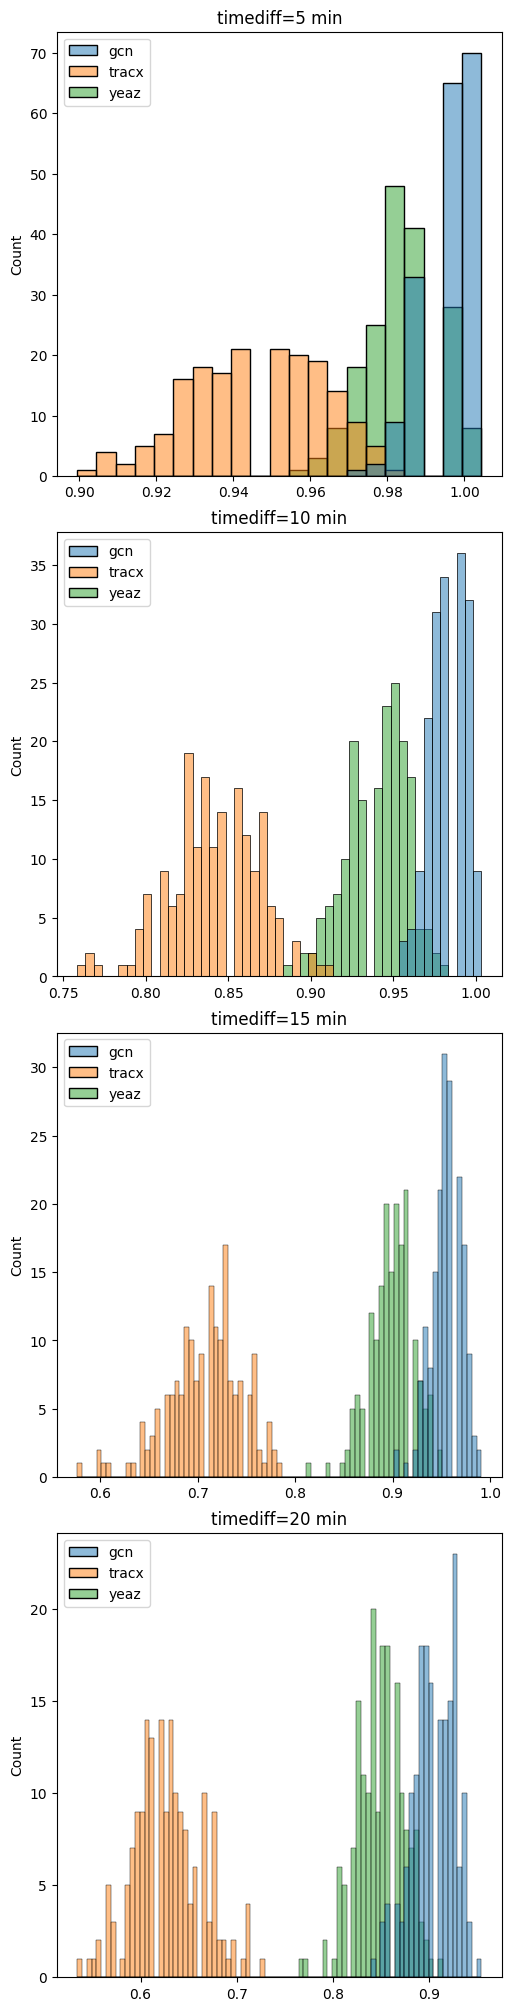

In [38]:
fig, axs = plt.subplots(nrows=res.timediff.nunique(), figsize=(5, 20), constrained_layout=True)

for ax, timediff in zip(axs, res.timediff.unique()):
	print(f'-- timediff = {timediff} --')

	# we resample ~180 times because that's the number of datapoints we have
	sample_gcn = bootstrap_sample(res.query('timediff == @timediff and method == "gcn"').acc.to_numpy(), n=180, agg=frac_perfect)
	sample_tracx = bootstrap_sample(res.query('timediff == @timediff and method == "tracx"').acc.to_numpy(), n=180, agg=frac_perfect)
	sample_yeaz = bootstrap_sample(res.query('timediff == @timediff and method == "yeaz"').acc.to_numpy(), n=180, agg=frac_perfect)

	sns.histplot(dict(gcn=sample_gcn, tracx=sample_tracx, yeaz=sample_yeaz), binwidth=0.005, ax=ax)
	ax.set_title(f'timediff={timediff} min')

	print(f't-test gcn <-> tracx : {ttest_ind(sample_gcn, sample_tracx)}')
	print(f't-test gcn <-> yeaz : {ttest_ind(sample_gcn, sample_yeaz)}')

## What induces mistakes ?

Expected 9->9, got 9->14
Expected 14->14, got 14->9


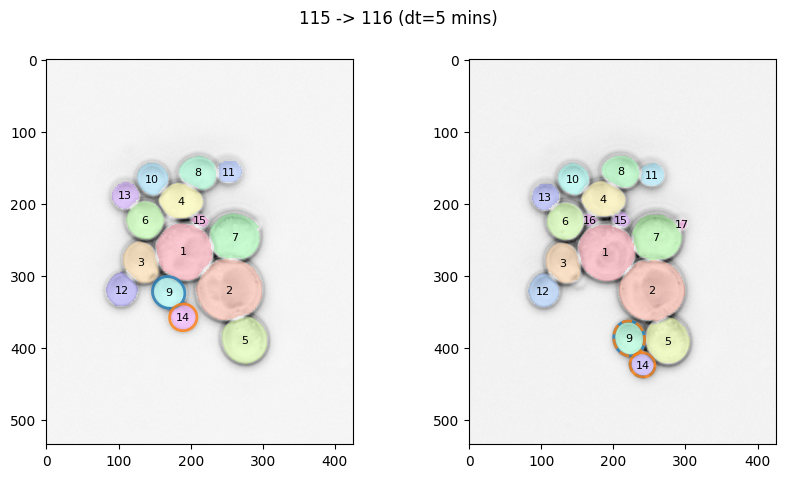

Expected 9->9, got 9->18
Expected 14->14, got 14->9


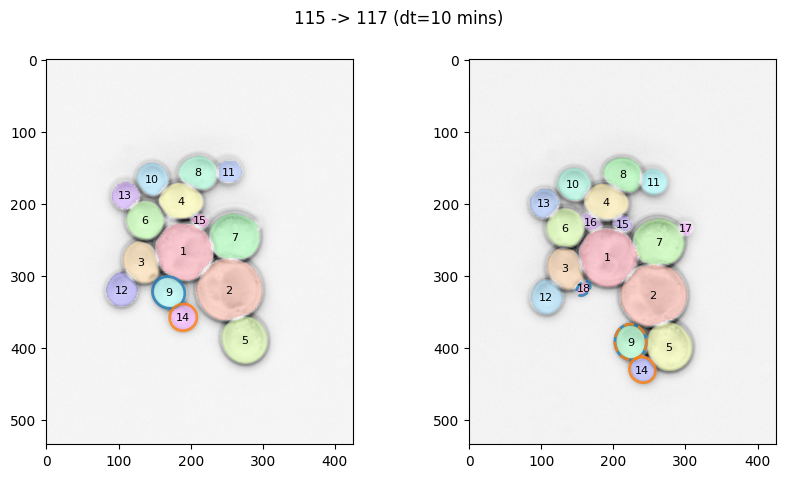

Expected 9->9, got 9->18
Expected 14->14, got 14->9


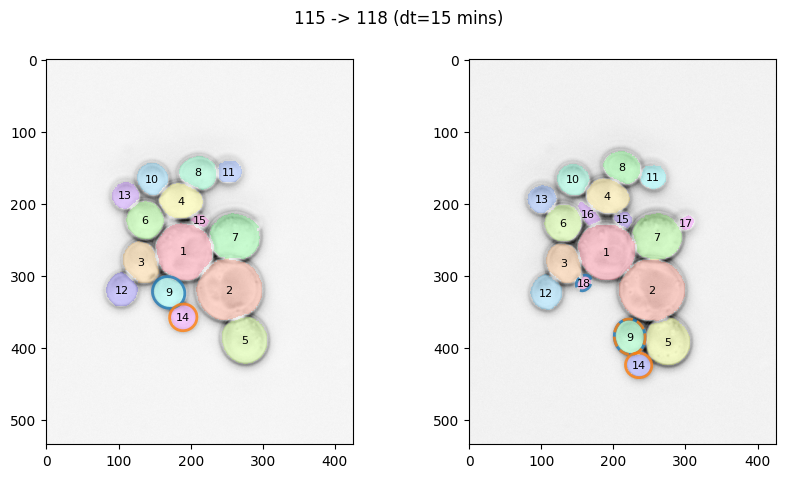

Expected 9->9, got 9->18
Expected 14->14, got 14->9


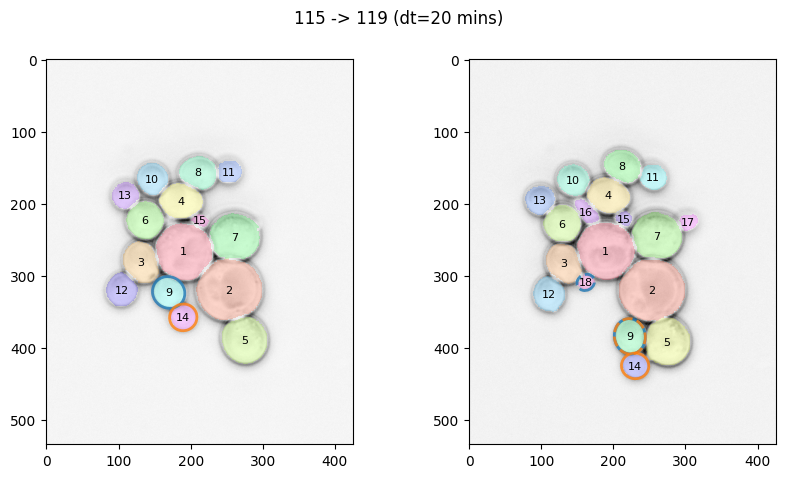

Expected 9->9, got 9->18


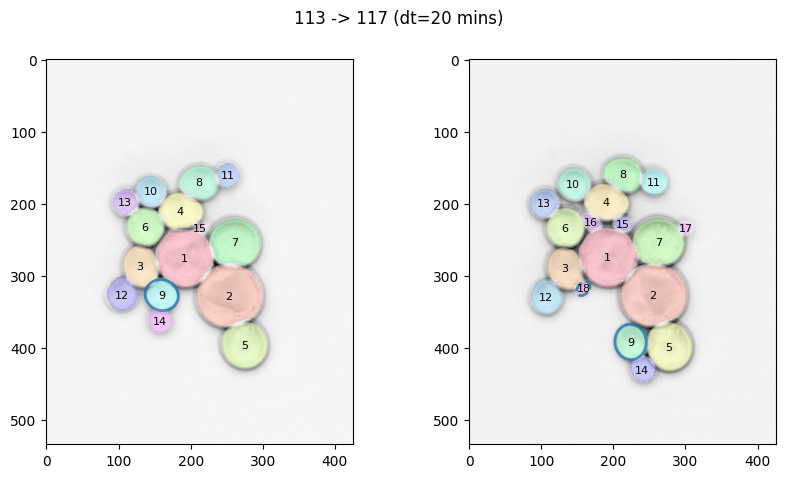

Expected 9->9, got 9->18


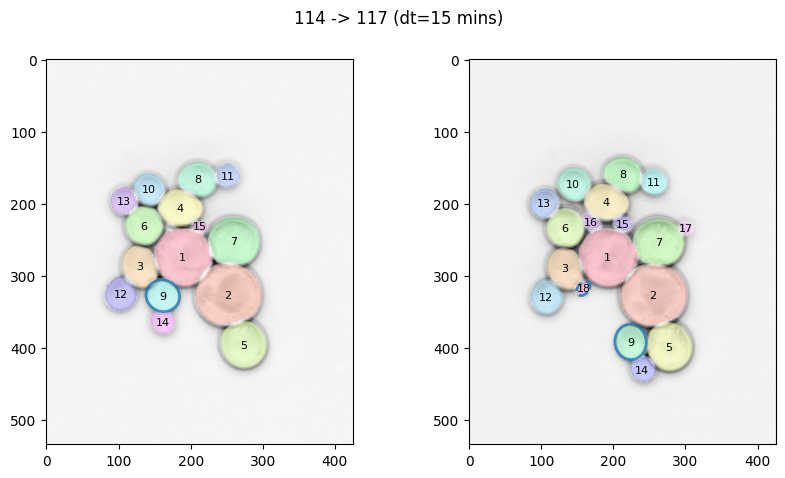

Expected 9->9, got 9->18


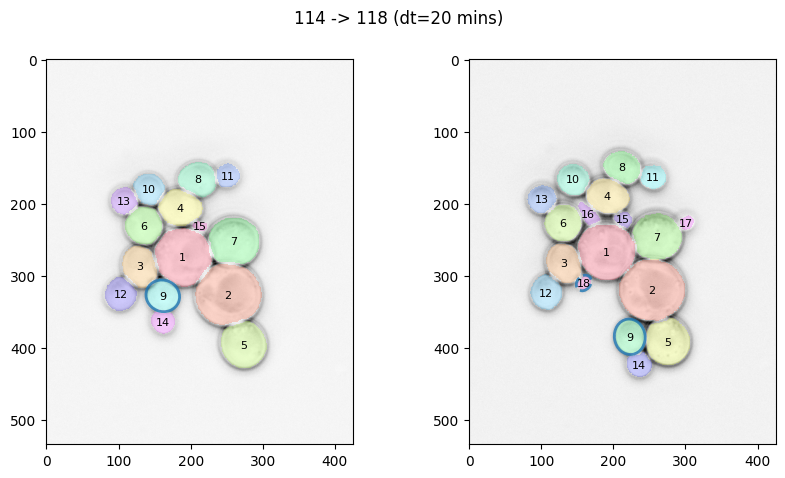

Expected 14->14, got 14->19


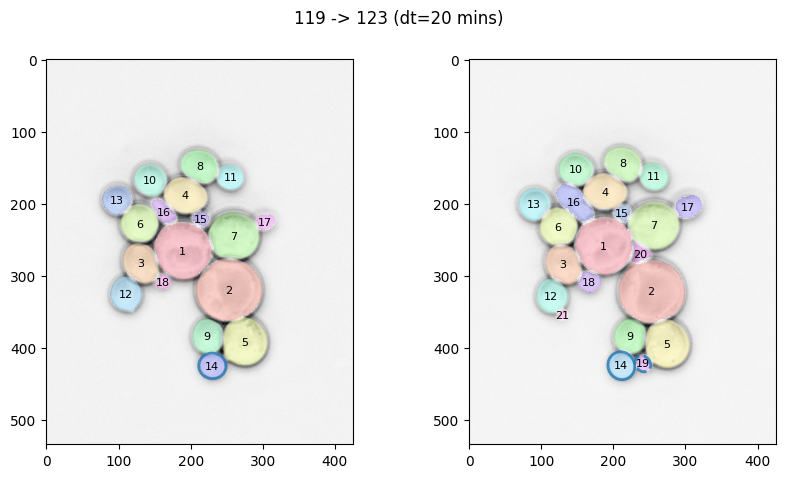

Expected 14->14, got 14->19


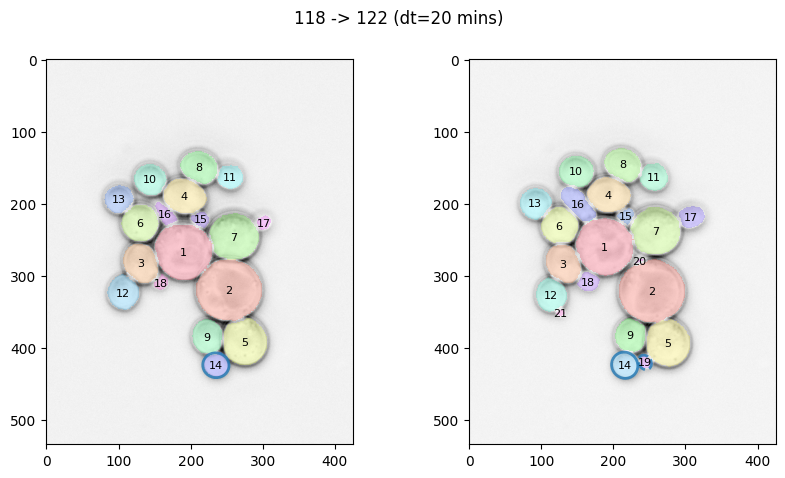

Expected 14->14, got 14->19


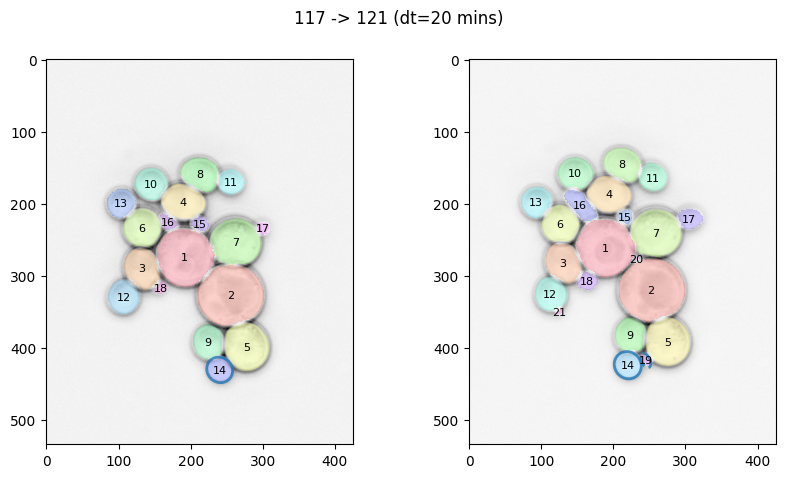

Expected 22->22, got 22->35
Expected 23->23, got 23->22
Expected 33->33, got 33->34


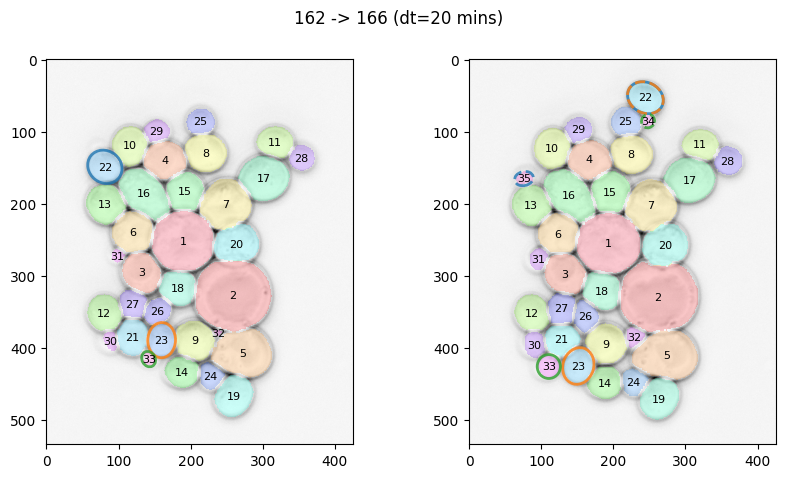

Expected 22->22, got 22->34
Expected 34->34, got 34->36


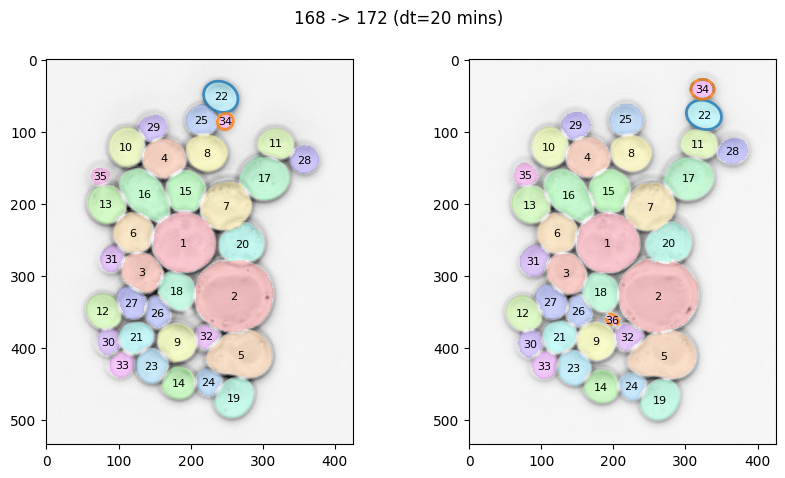

Expected 28->28, got 28->30


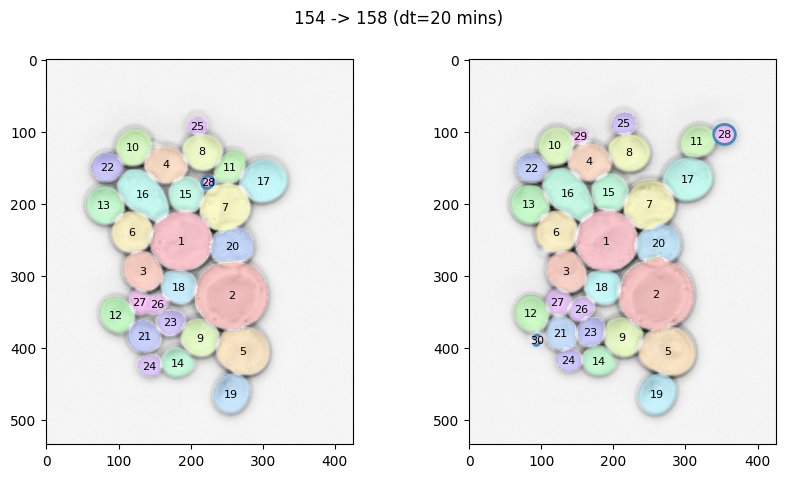

Expected 28->28, got 28->30


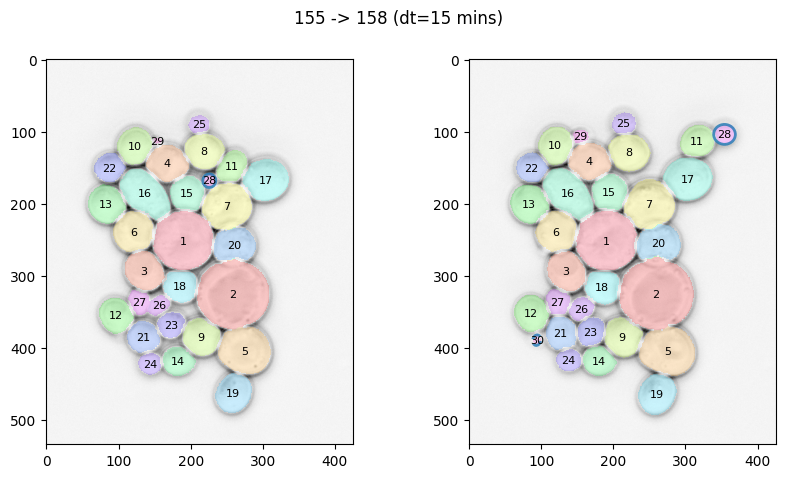

Expected 28->28, got 28->30


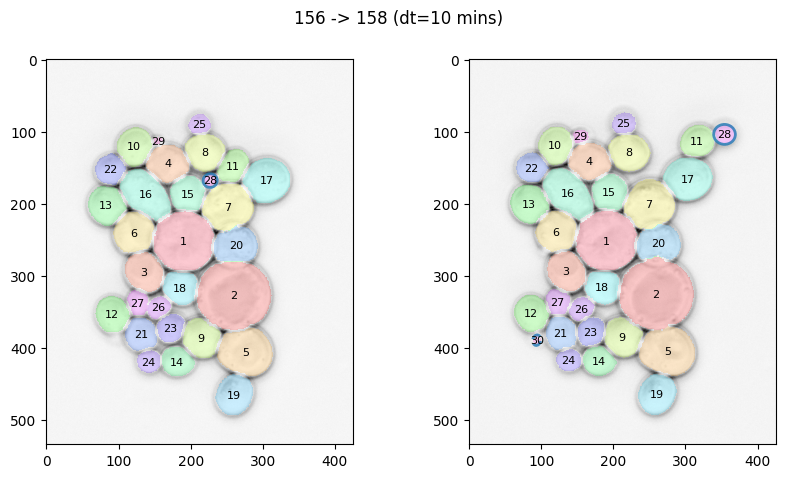

Expected 28->28, got 28->30


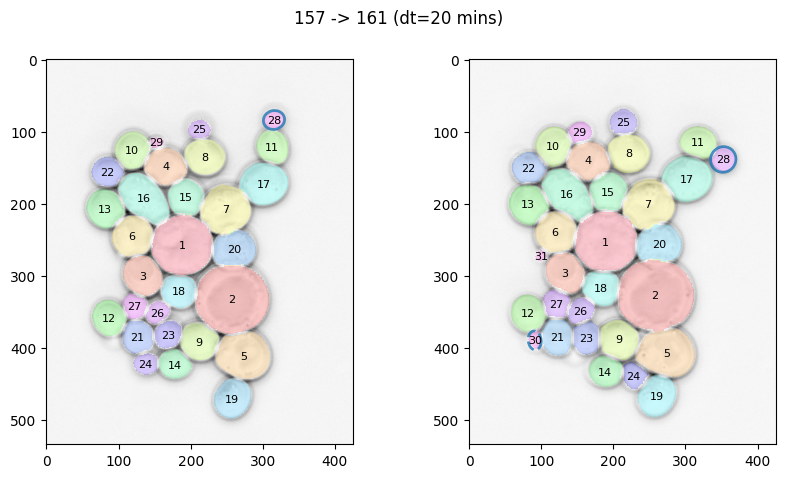

Expected 28->28, got 28->30


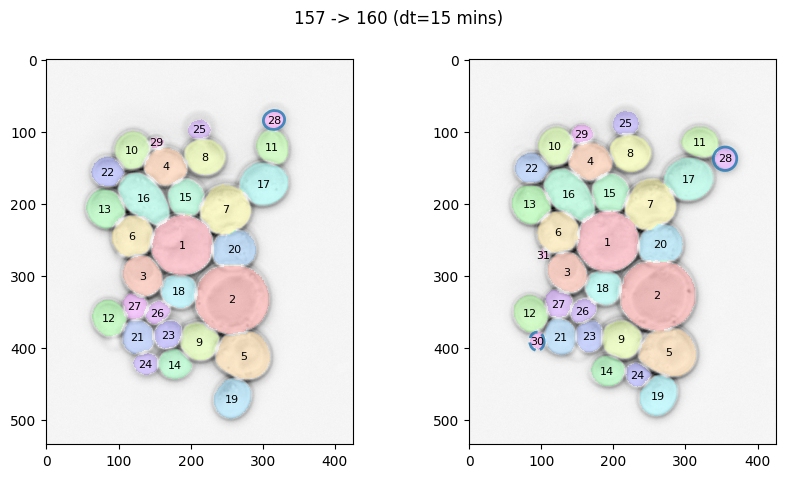

Expected 28->28, got 28->30


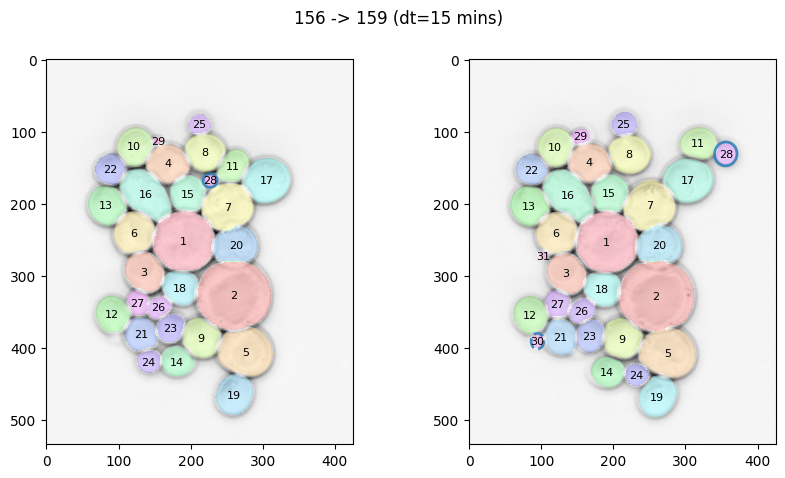

Expected 28->28, got 28->30


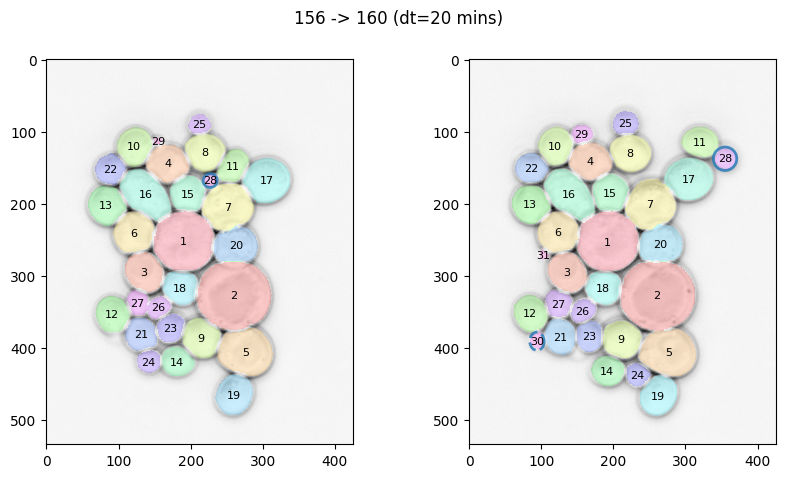

Expected 28->28, got 28->30


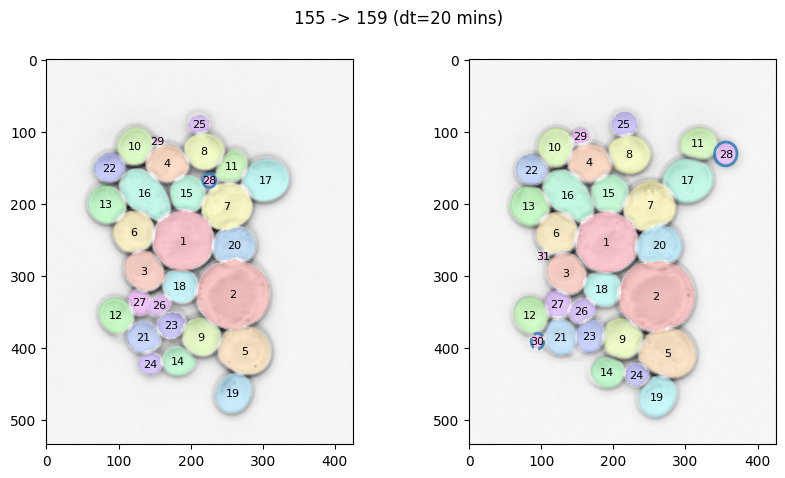

Expected 28->28, got 28->30


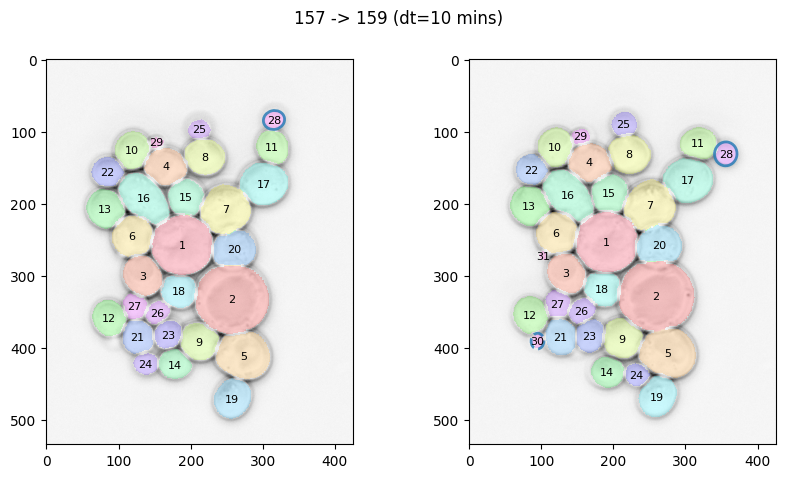

Expected 24->24, got 24->33


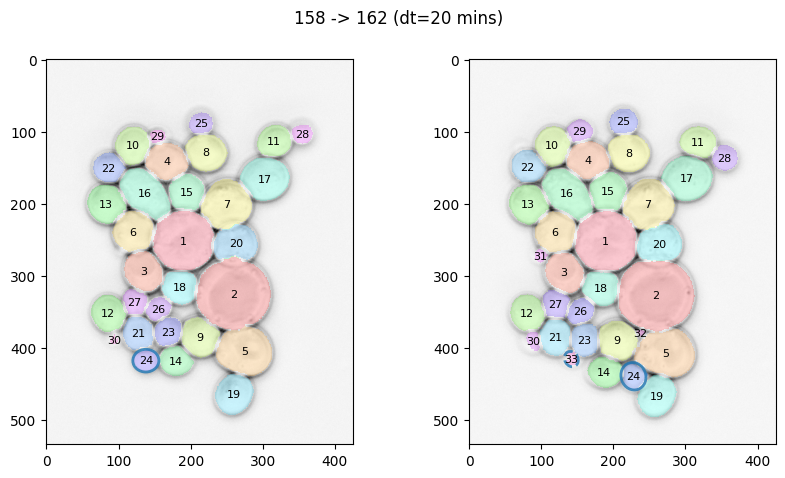

Expected 22->22, got 22->35


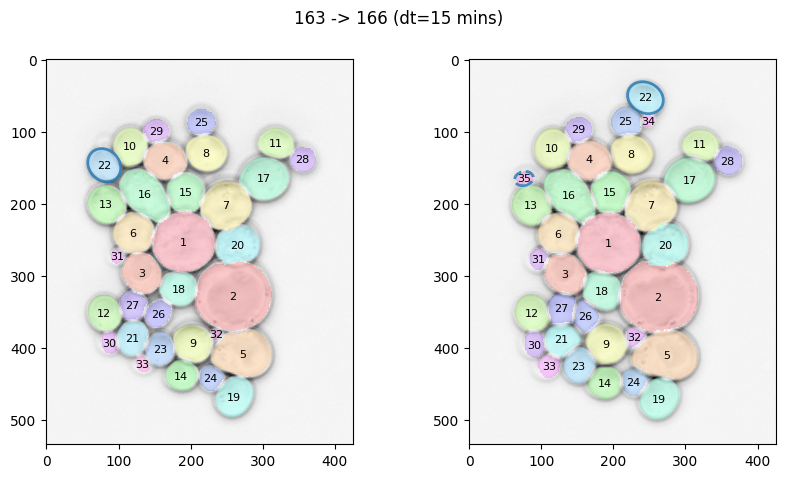

Expected 22->22, got 22->35


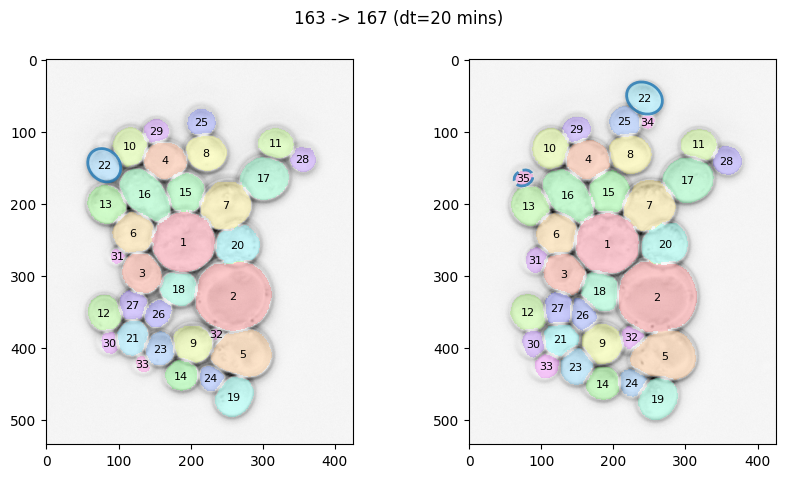

Expected 26->26, got 26->37


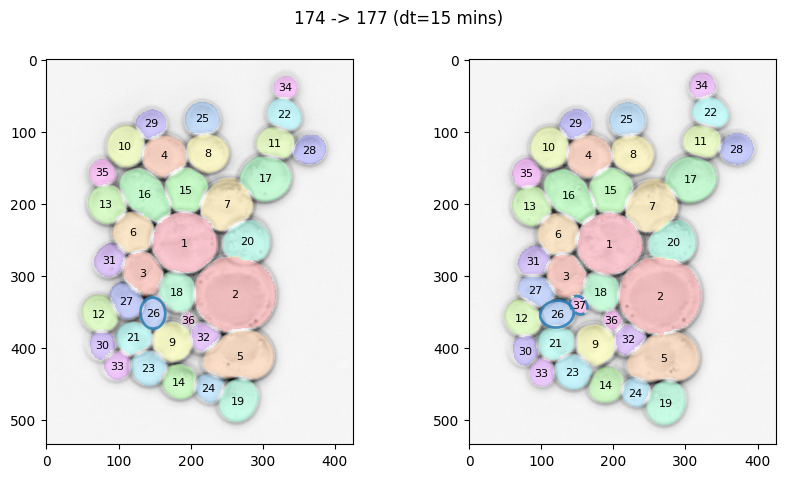

Expected 26->26, got 26->37


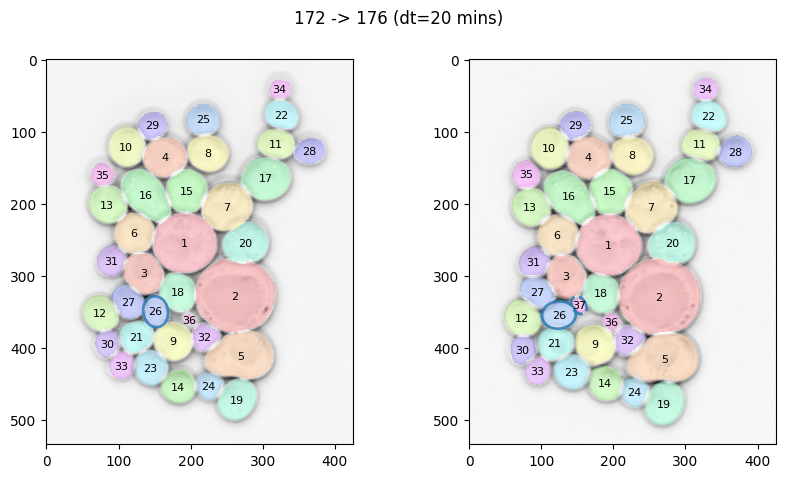

Expected 26->26, got 26->37


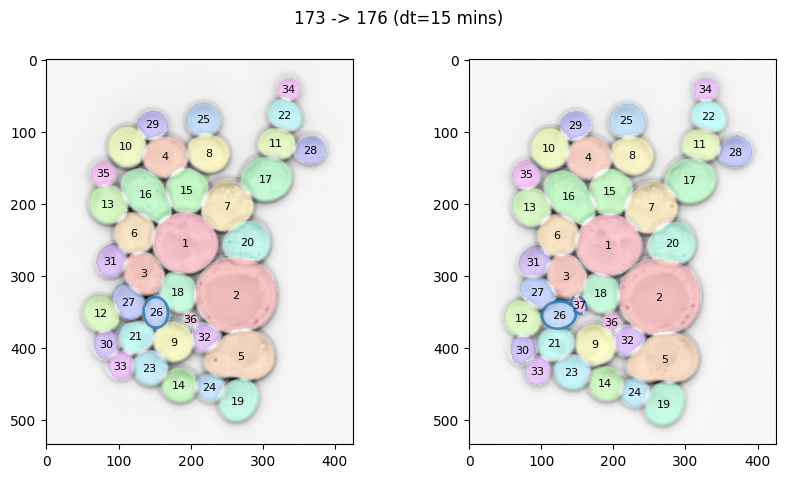

Expected 26->26, got 26->37


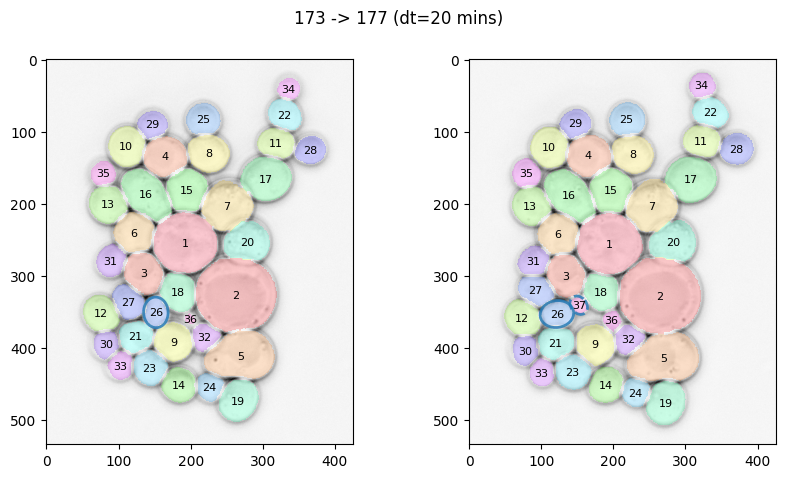

Expected 26->26, got 26->37


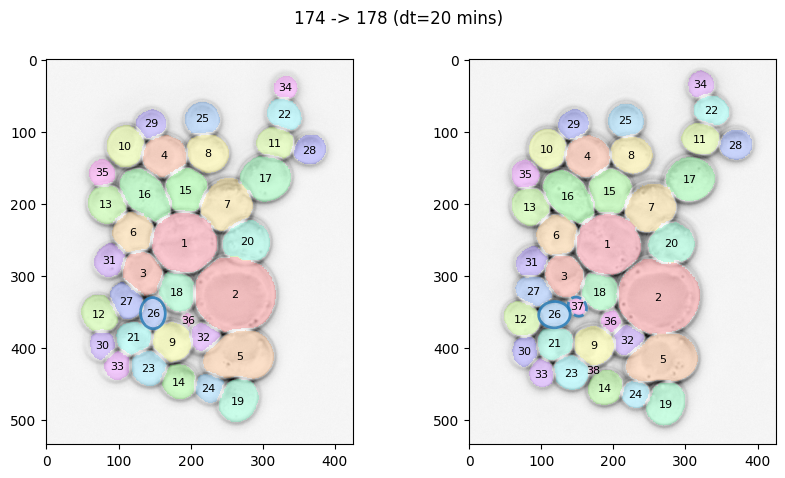

In [107]:
for _, row in res.query('(method == "gcn") and (fp > 0 or fn > 0)').sort_values('acc').iterrows():
	fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
	vis.plot_visible(microscopy, row.t1, figax=(fig, axs[0]))
	vis.plot_segmentation(seg, row.t1, figax=(fig, axs[0]), cellids=True, alpha=0.2)
	vis.plot_visible(microscopy, row.t2, figax=(fig, axs[1]))
	vis.plot_segmentation(seg, row.t2, figax=(fig, axs[1]), cellids=True, alpha=0.2)
	fig.suptitle(f'{row.t1} -> {row.t2} (dt={row.timediff} mins)')
	ga = tracking.build_assgraph(tracking.build_cellgraph(feat, row.t1), tracking.build_cellgraph(feat, row.t2), include_target_feature=True)
	gat, *_ = tracking.to_data(ga)
	yhat = net.predict_assignment(gat)
	y = gat.y.cpu().numpy().reshape(yhat.shape)
	cellids1, cellids2 = seg.cell_ids(row.t1), seg.cell_ids(row.t2)
	coloriter = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
	for idx1, (idx2, idx2_hat) in enumerate(zip(np.argmax(y, axis=1), np.argmax(yhat, axis=1))):
		if idx2 != idx2_hat:
			color = next(coloriter)
			print(f'Expected {cellids1[idx1]}->{cellids2[idx2]}, got {cellids1[idx1]}->{cellids2[idx2_hat]}')
			vis._vis._plot_ellipse(feat._ellipse(cellids1[idx1], row.t1), figax=(fig, axs[0]), color=color, linewidth=2, alpha=0.8, draw_axes=False)
			vis._vis._plot_ellipse(feat._ellipse(cellids2[idx2], row.t2), figax=(fig, axs[1]), color=color, linewidth=2, alpha=0.8, draw_axes=False)
			vis._vis._plot_ellipse(feat._ellipse(cellids2[idx2_hat], row.t2), figax=(fig, axs[1]), color=color, linestyle='--', linewidth=2, alpha=0.8, draw_axes=False)
	plt.show()